In [1]:
import sys
import os
import time
from tqdm.notebook import tqdm
from time import sleep
sys.path.append('..')

In [2]:
from awsdet.utils.misc.config import Config
from awsdet.utils.logger import get_root_logger
from awsdet.utils.runner.dist_utils import init_dist
from awsdet.datasets.data_generator import DataGenerator
from awsdet.datasets import build_dataset
from awsdet.datasets.loader.build_loader import build_dataloader
import tensorflow as tf
import matplotlib.pyplot as plt

from awsdet.datasets.data_generator import DataGenerator

In [3]:
import matplotlib.patches as patches
%matplotlib inline

def get_original_image(img):
    img = tf.reverse(img, axis=[-1])
    img = (img * \
       [1., 1., 1.] + \
       [123.675, 116.28, 103.53])/255.
    #img = img[:img_instance['img_metas']['img_shape'][0], :img_instance['img_metas']['img_shape'][1], :]
    return img

def show_box(img, bbox):
    img = get_original_image(img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    y1 = bbox[1]
    x1 = bbox[0]
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    rect = patches.Rectangle((y1,x1),h,w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [4]:
#config_path = '/workspace/shared_workspace/deep-learning-models/configs/rpn/rpn_r50_fpn_1x_coco.py'
config_path = '../configs/faster_rcnn/EC2/faster_rcnn_r50_fpn_1x_coco.py'
cfg = Config.fromfile(config_path)
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
cfg.work_dir = os.path.join('./work_dirs',
                                os.path.splitext(os.path.basename(config_path))[0])
log_file = os.path.join(cfg.work_dir, f'{timestamp}.log')


In [5]:
init_dist()

In [6]:
coco = build_dataset(cfg.data.train)

loading annotations into memory...
Done (t=15.28s)
creating index...
index created!


In [7]:
train_tdf, train_size = build_dataloader(coco, 4)
train_tdf_iter = iter(train_tdf.prefetch(32).repeat())

In [8]:
imgs, img_metas, gt_bboxes, gt_labels = next(train_tdf_iter)

Starting new loop for GPU: 0


In [9]:
from awsdet.models.builder import build_backbone, build_neck, build_head
#from awsdet.core.anchor import build_anchor_generator

In [10]:
backbone = build_backbone(cfg.model.backbone)
neck = build_neck(cfg.model.neck)
rpn_head = build_head(cfg.model.rpn_head)

In [11]:
backbone.layers[0].load_weights(cfg.model.backbone.weights_path)

In [12]:
from tqdm.notebook import tqdm

In [13]:
@tf.function
def forward(imgs):
    C2, C3, C4, C5 = backbone(imgs)
    P2, P3, P4, P5, P6 = neck((C2, C3, C4, C5))
    rpn_feature_maps = [P2, P3, P4, P5, P6]
    rpn_class_logits, rpn_probs, rpn_deltas = rpn_head(rpn_feature_maps)
    return rpn_class_logits, rpn_probs, rpn_deltas

In [14]:
imgs, img_metas, gt_bboxes, gt_labels = next(train_tdf_iter)
rpn_class_logits, rpn_probs, rpn_deltas = forward(imgs)


In [15]:
feature_maps_sizes = [tf.shape(i)[1:3] for i in rpn_class_logits]
anchors, valid_flags = rpn_head.get_anchors(feature_maps_sizes, img_metas)

In [16]:
flat_anchors = tf.concat(anchors[0], axis=0)
flat_flags = tf.concat(valid_flags[0], axis=0)

In [17]:
from awsdet.core.bbox import build_assigner
from awsdet.core.bbox import build_sampler
from awsdet.core.bbox import build_bbox_coder

In [18]:
assigner_config = dict(type="MaxIoUAssigner",
                       pos_iou_thr=0.7,
                       neg_iou_thr=0.3,
                       min_pos_iou=0.3,
                       match_low_quality=True,
                       ignore_iof_thr=-1)
sampler_config = dict(type="RandomSampler",
                      num=256,
                      pos_fraction=0.5,
                      neg_pos_ub=-1,
                      add_gt_as_proposals=False)
coder_config = dict(type="DeltaYXHWBBoxCoder")

assigner = build_assigner(assigner_config)
sampler = build_sampler(sampler_config)
bbox_coder = build_bbox_coder(coder_config)

In [28]:
def _get_targets_single(flat_anchors,
                        valid_flags,
                        gt_bboxes,
                        img_meta,
                        gt_labels=None,
                        gt_bboxes_ignore=None,
                        label_channels=1,
                        unmap_outputs=True):
    anchors = tf.boolean_mask(flat_anchors, valid_flags)
    # get assignments
    num_gts, gt_inds, max_overlaps, labels = assigner.assign(flat_anchors, 
                                    gt_bboxes, valid_flags, 
                                    gt_labels=gt_labels)
    # sample from assignments
    pos_inds, neg_inds, pos_bboxes, \
    neg_bboxes, pos_gt_bboxes, \
    pos_assigned_gt_inds, pos_gt_labels = sampler.sample(num_gts, gt_inds, 
                                     max_overlaps, labels, 
                                     flat_anchors, gt_bboxes, gt_labels)
    num_valid_anchors = tf.shape(flat_anchors)[0]
    bbox_targets = tf.zeros_like(flat_anchors, dtype=flat_anchors.dtype)
    bbox_weights = tf.zeros_like(flat_anchors, dtype=flat_anchors.dtype)
    labels = tf.zeros(num_valid_anchors, dtype=gt_labels.dtype)
    label_weights = tf.zeros(num_valid_anchors, dtype=flat_anchors.dtype)
    if len(pos_inds) > 0:
        pos_bbox_targets = bbox_coder.encode(
                pos_bboxes, pos_gt_bboxes)
    else:
        pos_bbox_targets = pos_gt_bboxes
    bbox_targets = tf.tensor_scatter_nd_update(bbox_targets,
                            tf.expand_dims(pos_inds, axis=1),
                            pos_bbox_targets)
    bbox_weights = tf.tensor_scatter_nd_update(bbox_weights,
                            tf.expand_dims(pos_inds, axis=1),
                            tf.ones_like(pos_bbox_targets))
    if gt_labels is None:
        labels = tf.tensor_scatter_nd_update(labels,
                    tf.expand_dims(pos_inds, axis=1),
                    tf.ones_like(pos_inds, dtype=labels.dtype))
    else:
        labels = tf.tensor_scatter_nd_update(labels,
                    tf.expand_dims(pos_inds, axis=1),
                    tf.gather(gt_labels, pos_assigned_gt_inds))
    label_weights = tf.tensor_scatter_nd_update(label_weights,
                    tf.expand_dims(pos_inds, axis=1),
                    tf.ones_like(pos_inds, dtype=label_weights.dtype))
    label_weights = tf.tensor_scatter_nd_update(label_weights,
                    tf.expand_dims(neg_inds, axis=1),
                    tf.ones_like(neg_inds, dtype=label_weights.dtype))
    return (labels, label_weights, bbox_targets, bbox_weights, pos_inds,
                neg_inds)
    return num_gts, gt_inds, max_overlaps, labels

@tf.function
def get_targets(anchor_list, valid_flag_list, gt_bboxes,
                img_metas, gt_labels, return_sampling_results=False):
    num_imgs = len(img_metas)
    assert len(anchor_list) == len(valid_flag_list) == num_imgs
    all_labels = tf.TensorArray(dtype=gt_labels.dtype, size=num_imgs)
    all_label_weights = tf.TensorArray(dtype=gt_bboxes.dtype, size=num_imgs)
    all_bbox_targets = tf.TensorArray(dtype=gt_bboxes.dtype, size=num_imgs)
    all_bbox_weights = tf.TensorArray(dtype=gt_bboxes.dtype, size=num_imgs)
    #pos_inds_list = tf.TensorArray(dtype=tf.int64, size=num_imgs)
    #neg_inds_list = tf.TensorArray(dtype=tf.int64, size=num_imgs)
    for i in range(num_imgs):
        flat_anchors = tf.concat(anchors[i], axis=0)
        flat_flags = tf.concat(valid_flags[i], axis=0)
        labels, label_weights, bbox_targets, \
        bbox_weights, pos_inds, \
        neg_inds = _get_targets_single(flat_anchors,
                                       flat_flags,
                                       gt_bboxes[i],
                                       img_metas[i],
                                       gt_labels[i])
        all_labels = all_labels.write(i, labels)
        all_label_weights = all_label_weights.write(i, label_weights)
        all_bbox_targets = all_bbox_targets.write(i, bbox_targets)
        all_bbox_weights = all_bbox_weights.write(i, bbox_weights)
        #pos_inds_list = pos_inds_list.write(i, pos_inds)
        #neg_inds_list = neg_inds_list.write(i, neg_inds)
    all_labels = all_labels.stack()
    all_label_weights = all_label_weights.stack()
    all_bbox_targets = all_bbox_targets.stack()
    all_bbox_weights = all_bbox_weights.stack()
    #pos_inds_list = pos_inds_list.stack()
    #neg_inds_list = neg_inds_list.stack()
    return (all_labels, all_label_weights, all_bbox_targets, 
                all_bbox_weights)

In [20]:
img = 3
flat_anchors = tf.concat(anchors[img], axis=0)
flat_flags = tf.concat(valid_flags[img], axis=0)
num_gts, gt_inds, max_overlaps, labels = _get_targets_single(flat_anchors, 
                    flat_flags, 
                    gt_bboxes[img],
                    img_metas[img],
                    gt_labels=gt_labels[img])

In [52]:
pos_inds = tf.squeeze(tf.where(gt_inds > 0))
if tf.rank(pos_inds)<1:
    pos_inds = tf.expand_dims(pos_inds, axis=0)
tf.shape(pos_inds)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [29]:
all_labels, all_label_weights, all_bbox_targets, \
all_bbox_weights = get_targets(anchors, valid_flags, gt_bboxes,
                img_metas, gt_labels)

In [30]:
all_bbox_weights

<tf.Tensor: shape=(4, 446118, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)>

In [21]:
all_labels, all_label_weights, all_bbox_targets, \
    all_bbox_weights,  = get_targets(anchors,
                                     valid_flags,
                                     gt_bboxes,
                                     img_metas,
                                     gt_labels)

TypeError: 'NoneType' object is not iterable

In [121]:
all_bbox_weights

<tf.Tensor: shape=(4, 446118, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)>

In [81]:
labels, label_weights, bbox_targets, bbox_weights, \
pos_inds, neg_inds, sampling_result = _get_targets_single(flat_anchors, 
                                                    flat_flags, 
                                                    gt_bboxes[0], 
                                                    img_metas[0], 
                                                    gt_labels[0])

In [94]:
labels[445510]

<tf.Tensor: shape=(), dtype=int32, numpy=56>

In [97]:
gt_labels

<tf.Tensor: shape=(4, 11), dtype=int32, numpy=
array([[43, 56,  1, 56, -1, -1, -1, -1, -1, -1, -1],
       [33,  1,  1, 14, 14, 14,  1, 74,  1, -1, -1],
       [44, 42, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [68, 61,  1,  1,  1,  1, 42,  1,  1, 42, 61]], dtype=int32)>

In [71]:
tf.tensor_scatter_nd_update(labels,
                            tf.expand_dims(sampling_result.pos_inds, axis=1),
                            tf.gather(gt_labels[0], sampling_result.pos_assigned_gt_inds))

<tf.Tensor: shape=(446118,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>

In [79]:
sampling_result.pos_inds

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([440191, 440304, 442831, 442957, 445507, 445510])>

In [66]:
preds = bbox_coder.decode(sampling_result.pos_bboxes, pos_bbox_targets)

In [41]:
preds

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[4.6667480e-01, 4.6794995e+02, 3.0613330e+02, 7.9818335e+02],
       [7.3500214e+00, 3.5954999e+02, 4.9633331e+02, 6.2321667e+02],
       [6.9373328e+02, 4.0181668e+02, 1.0025666e+03, 6.8391675e+02],
       [6.9373328e+02, 4.0181668e+02, 1.0025666e+03, 6.8391675e+02],
       [4.6021674e+02, 1.9176666e+02, 9.6838342e+02, 6.0404999e+02],
       [4.6021674e+02, 1.9176666e+02, 9.6838342e+02, 6.0404999e+02]],
      dtype=float32)>

In [42]:
gt_bboxes[0]

<tf.Tensor: shape=(11, 4), dtype=float32, numpy=
array([[7.3499994e+00, 3.5954999e+02, 4.9633331e+02, 6.2321661e+02],
       [4.6021667e+02, 1.9176666e+02, 9.6838336e+02, 6.0404999e+02],
       [4.6666667e-01, 4.6794998e+02, 3.0613330e+02, 7.9818335e+02],
       [6.9373328e+02, 4.0181665e+02, 1.0025666e+03, 6.8391669e+02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


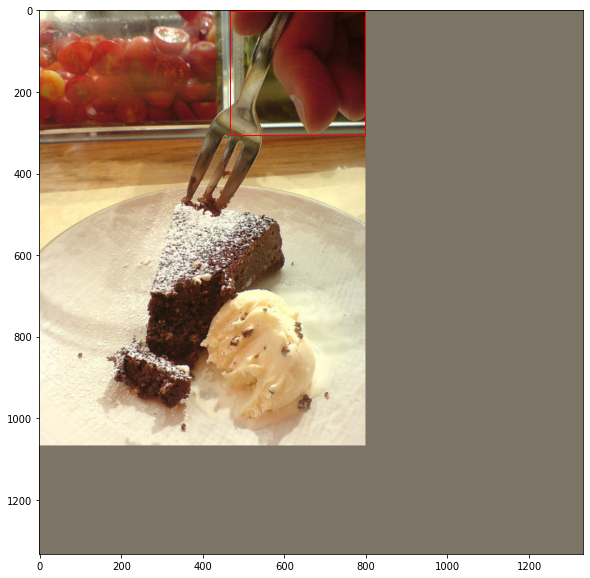

In [65]:
show_box(imgs[0], preds[0])

In [45]:
get_targets(anchor_list,
            valid_flag_list,
            gt_bboxes,
            img_metas,
            gt_labels_list=None,
            label_channels=1
            unmap_outputs=True,
            return_sampling_results=False):
    num_imgs = len(img_metas)
    assert len(anchor_list) == len(valid_flag_list) == num_imgs
    num_level_anchors = [tf.size(anchors)[0] for anchors in anchor_list[0]]
    

def loss(cls_scores,
        bbox_preds,
        gt_bboxes,
        gt_labels,
        img_metas):
    featmap_sizes = [tf.shape(featmap)[1:3] for featmap in cls_scores]
    assert len(featmap_sizes) == rpn_head.anchor_generator.num_levels
    anchor_list, valid_flag_list = rpn_head.get_anchors(
            featmap_sizes, img_metas)
    

In [46]:
loss(rpn_probs, rpn_deltas, gt_bboxes, gt_labels, img_metas)

([[<tf.Tensor: shape=(334668, 4), dtype=float32, numpy=
   array([[ -22.627417,  -11.313708,   22.627417,   11.313708],
          [ -16.      ,  -16.      ,   16.      ,   16.      ],
          [ -11.313708,  -22.627417,   11.313708,   22.627417],
          ...,
          [1309.3726  , 1320.6863  , 1354.6274  , 1343.3137  ],
          [1316.      , 1316.      , 1348.      , 1348.      ],
          [1320.6863  , 1309.3726  , 1343.3137  , 1354.6274  ]],
         dtype=float32)>,
   <tf.Tensor: shape=(83667, 4), dtype=float32, numpy=
   array([[ -45.254833,  -22.627417,   45.254833,   22.627417],
          [ -32.      ,  -32.      ,   32.      ,   32.      ],
          [ -22.627417,  -45.254833,   22.627417,   45.254833],
          ...,
          [1282.7451  , 1305.3726  , 1373.2549  , 1350.6274  ],
          [1296.      , 1296.      , 1360.      , 1360.      ],
          [1305.3726  , 1282.7451  , 1350.6274  , 1373.2549  ]],
         dtype=float32)>,
   <tf.Tensor: shape=(21168, 4), dtyp